## PLN1 - Procesamiento del Lenguaje Natural I ##

Nombre: José Aviani

Código: a2103

### Desafío 4 ###

#### Parte 1 ####

---

No vamos a hacer comentarios ni aclaraciones adicionales a todo lo que fue simplemente tomado de la notebook presentada en clase. Respecto a esa notebook, se aplicaron los siguientes cambios y agregados:

**1. Extensión de los entrenamientos a más datos y tamaños de secuencias mayores.**

**2. Búsqueda de hiperparámetros.**

**3. Embeddings pre-entreados en español.**

**4. Prueba con diferentes cantidades de neuronas en las capas recurrentes.**

**5. Implementación de dos estrategias de generación nuevas:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**1. Sampling.**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**2. Beam Search.**

---

Parámetros:

Google Colab Pro provee hasta 167.1 GB de RAM. Con esos recursos, pudimos usar el máximo largo de las sentencias en inglés y español, pero tuvimos que limitar la cantidad de sentencias a utilizar:

In [ ]:
LIMITE_MAX_NUM_SENTENCES = 30000 # Máximo soportado
LIMITE_MAX_INPUT_LEN = 32 # 32 es la entrada más larga en inglés
LIMITE_MAX_OUT_LEN = 36 # 36 es la salida más larga en español

Epochs de los entrenamientos y combinaciones de hiperparámetros para búsqueda del mejor modelo:

1. Diferente cantidad de neuronas en las capas recurrentes.

2. Embeddings de salida sin y con pre-entrenamiento.

In [ ]:
# Epochs de los entrenamientos
EPOCHS = 18

# Hiperparámetros
UNITS_LIST = [64, 128, 256]
SALIDA_PRE_ENTRENADA_LIST = [False, True]

Hacemos todos los imports necesarios:

In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import os
import gdown
import logging
import os
from pathlib import Path
from io import StringIO
import pickle
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import os, urllib.request, gzip, shutil

In [3]:
INICIO_EJECUCION = datetime.datetime.now()
INICIO_STEP = datetime.datetime.now()

Descargamos el dataset:

In [4]:
# Descargar la carpeta de dataset
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2576k  100 2576k    0     0  1763k      0  0:00:01  0:00:01 --:--:-- 1762k


Cargamos las sentencias:

In [5]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if LIMITE_MAX_NUM_SENTENCES > 0 and count > LIMITE_MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 30000


In [6]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

In [ ]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

Tokenizador de inglés:

In [ ]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 8121
Sentencia de entrada más larga: 32


Tokenizador de español:

In [ ]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 13979
Sentencia de salida más larga: 36


Límites de las sentencias en inglés y español. Pudimos utilizar los máximos de los dos idiomas.

In [10]:
if LIMITE_MAX_INPUT_LEN > 0:
    max_input_len = LIMITE_MAX_INPUT_LEN
if LIMITE_MAX_OUT_LEN > 0:
    max_out_len = LIMITE_MAX_OUT_LEN

In [11]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 30000
encoder_input_sequences shape: (30000, 32)
decoder_input_sequences shape: (30000, 36)


In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(30000, 36, 8000)

Descargamos los embeddings de una copia en nuestro Google Drive:

In [13]:
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=113Az8prTOoctmAgaAYty2IA83oEmxa9v'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=113Az8prTOoctmAgaAYty2IA83oEmxa9v
From (redirected): https://drive.google.com/uc?id=113Az8prTOoctmAgaAYty2IA83oEmxa9v&confirm=t&uuid=c5bc61a4-d182-4348-9786-0e8fb4a10e01
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:07<00:00, 72.6MB/s]


In [ ]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [15]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

Embeddings en inglés:

In [ ]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 97


Embeddings en español:

In [ ]:
# Descargar fastText Spanish (.vec) si no está
FT_ES_VEC_GZ = "cc.es.300.vec.gz"
FT_ES_VEC    = "cc.es.300.vec"
if not os.path.exists(FT_ES_VEC):
    if not os.path.exists(FT_ES_VEC_GZ):
        url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz"
        print("Descargando:", url)
        urllib.request.urlretrieve(url, FT_ES_VEC_GZ)

    print("Descomprimiendo:", FT_ES_VEC_GZ, "->", FT_ES_VEC)
    with gzip.open(FT_ES_VEC_GZ, "rb") as f_in, open(FT_ES_VEC, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
else:
    print("OK:", FT_ES_VEC, "ya existe")

# Definir wrapper (subclase) para español
class FasttextEmbeddingsES(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = FT_ES_VEC
    PKL_PATH = "fasttext_es.pkl"
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

# Instanciar embeddings en español
model_embeddings_es = FasttextEmbeddingsES()
print("model_embeddings_es listo. Dim:", model_embeddings_es.N_FEATURES)

Descargando: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Descomprimiendo: cc.es.300.vec.gz -> cc.es.300.vec
model_embeddings_es listo. Dim: 300


Creeamos dos decoders: uno con embeddings sin pre-entrenar y otro con embeddings pre-entrenados:

In [ ]:
DEC_EMBED_DIM = 128  # fijo (constante en todos los experimentos)

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)


# Decoder con embeddings sin pre-entrenar
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=DEC_EMBED_DIM, input_length=max_out_len)
decoder_inputs_spe = decoder_embedding_layer(decoder_inputs)


# Decoder con embeddings pre-entrenados
embed_dim_out = model_embeddings_es.N_FEATURES
nb_words_out = min(MAX_VOCAB_SIZE, len(word2idx_outputs))
embedding_matrix_outputs = np.zeros((nb_words_out, embed_dim_out))
words_not_found_out = []
for word, i in word2idx_outputs.items():
    if i >= nb_words_out:
        continue
    vec = model_embeddings_es.get_words_embeddings(word)[0]
    if (vec is not None) and len(vec) > 0:
        embedding_matrix_outputs[i] = vec
    else:
        words_not_found_out.append(word)
decoder_embedding_layer_cpe = Embedding(
    input_dim=nb_words_out,
    output_dim=embed_dim_out,
    input_length=max_out_len,
    weights=[embedding_matrix_outputs],
    trainable=False  # o True si querés fine-tuning (probalo)
)
decoder_inputs_cpe = decoder_embedding_layer_cpe(decoder_inputs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entrenamos con estos agregados respecto a la notebook presentada en clase:

1. Búsqueda de hiperparámetros:

    1. Diferentes cantidades de neuronas en las capas recurrentes.

    2. Decoders sin y con embeddings pre-entrenados.

2. Early Stopping.

3. Dropout para reducir overfitting

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    min_delta=1e-3
)

results = []
best_val = float("inf")
best_units = None
best_pe = None

for n_units in UNITS_LIST:
    for pe in SALIDA_PRE_ENTRENADA_LIST:

        print('-'*120)
        print('Entrenando:')
        print(f'   n_units =', n_units)
        print(f'   Embeddings de salida pre-entrenados =', pe)

        tf.keras.backend.clear_session()

        # Dropout para reducir overfitting
        LSTM_DROPOUT = 0.2
        REC_DROPOUT  = 0.2

        encoder = LSTM(n_units, return_state=True, dropout=LSTM_DROPOUT, recurrent_dropout=REC_DROPOUT)
        encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
        encoder_states = [state_h, state_c]

        decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=LSTM_DROPOUT, recurrent_dropout=REC_DROPOUT)

        decoder_outputs, _, _ = decoder_lstm(decoder_inputs_spe if not pe else decoder_inputs_cpe, initial_state=encoder_states)

        # Dense
        decoder_dense = Dense(num_words_output, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

        hist = model.fit(
            [encoder_input_sequences, decoder_input_sequences],
            decoder_targets,
            epochs=EPOCHS,
            validation_split=0.2,
            callbacks=[early_stop])

        val = min(hist.history["val_loss"])
        results.append((n_units, val))

        if val < best_val:
            best_val = val
            best_units = n_units
            best_pe = pe
            model.save("best_seq2seq.keras")  # guarda el mejor

        print('-'*120)
        print("")



model = tf.keras.models.load_model("best_seq2seq.keras")
n_units = best_units
print("Mejor modelo: n_units =", n_units, ", embeddings de salida pre-entrenados =", best_pe, ", best val_loss =", best_val)
model.summary()

------------------------------------------------------------------------------------------------------------------------
Entrenando:
   n_units = 64
   Embeddings de salida pre-entrenados = False
Epoch 1/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 103s 128ms/step - accuracy: 0.8098 - loss: 2.6678 - val_accuracy: 0.8442 - val_loss: 1.0626
Epoch 2/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.8459 - loss: 1.0435 - val_accuracy: 0.8504 - val_loss: 0.9950
Epoch 3/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.8498 - loss: 0.9832 - val_accuracy: 0.8556 - val_loss: 0.9399
Epoch 4/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 113ms/step - accuracy: 0.8560 - loss: 0.9201 - val_accuracy: 0.8596 - val_loss: 0.8945
Epoch 5/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.8600 - loss: 0.8701 - val_accuracy: 0.8618 - val_loss: 0.8645
Epoch 6/18
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.8627 - loss: 0.8332 - val_accuracy: 0.8641 - val_loss: 0.8421
Epoch 7/18
750/75

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 50)    │    400,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 36, 128)   │  1,024,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    314,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 36, 256), │    394,240 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 36, 8000)  │  2,056,000 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,765,826 (44.88 MB)

 Trainable params: 3,788,608 (14.45 MB)

 Non-trainable params: 400,000 (1.53 MB)

 Optimizer params: 7,577,218 (28.90 MB)

**El mejor modelo es:**
  1. n_units = 256
  2. Embeddings de salida pre-entrenados = False
  3. Mejor val_loss = 0.7114
  4. Epochs = 12

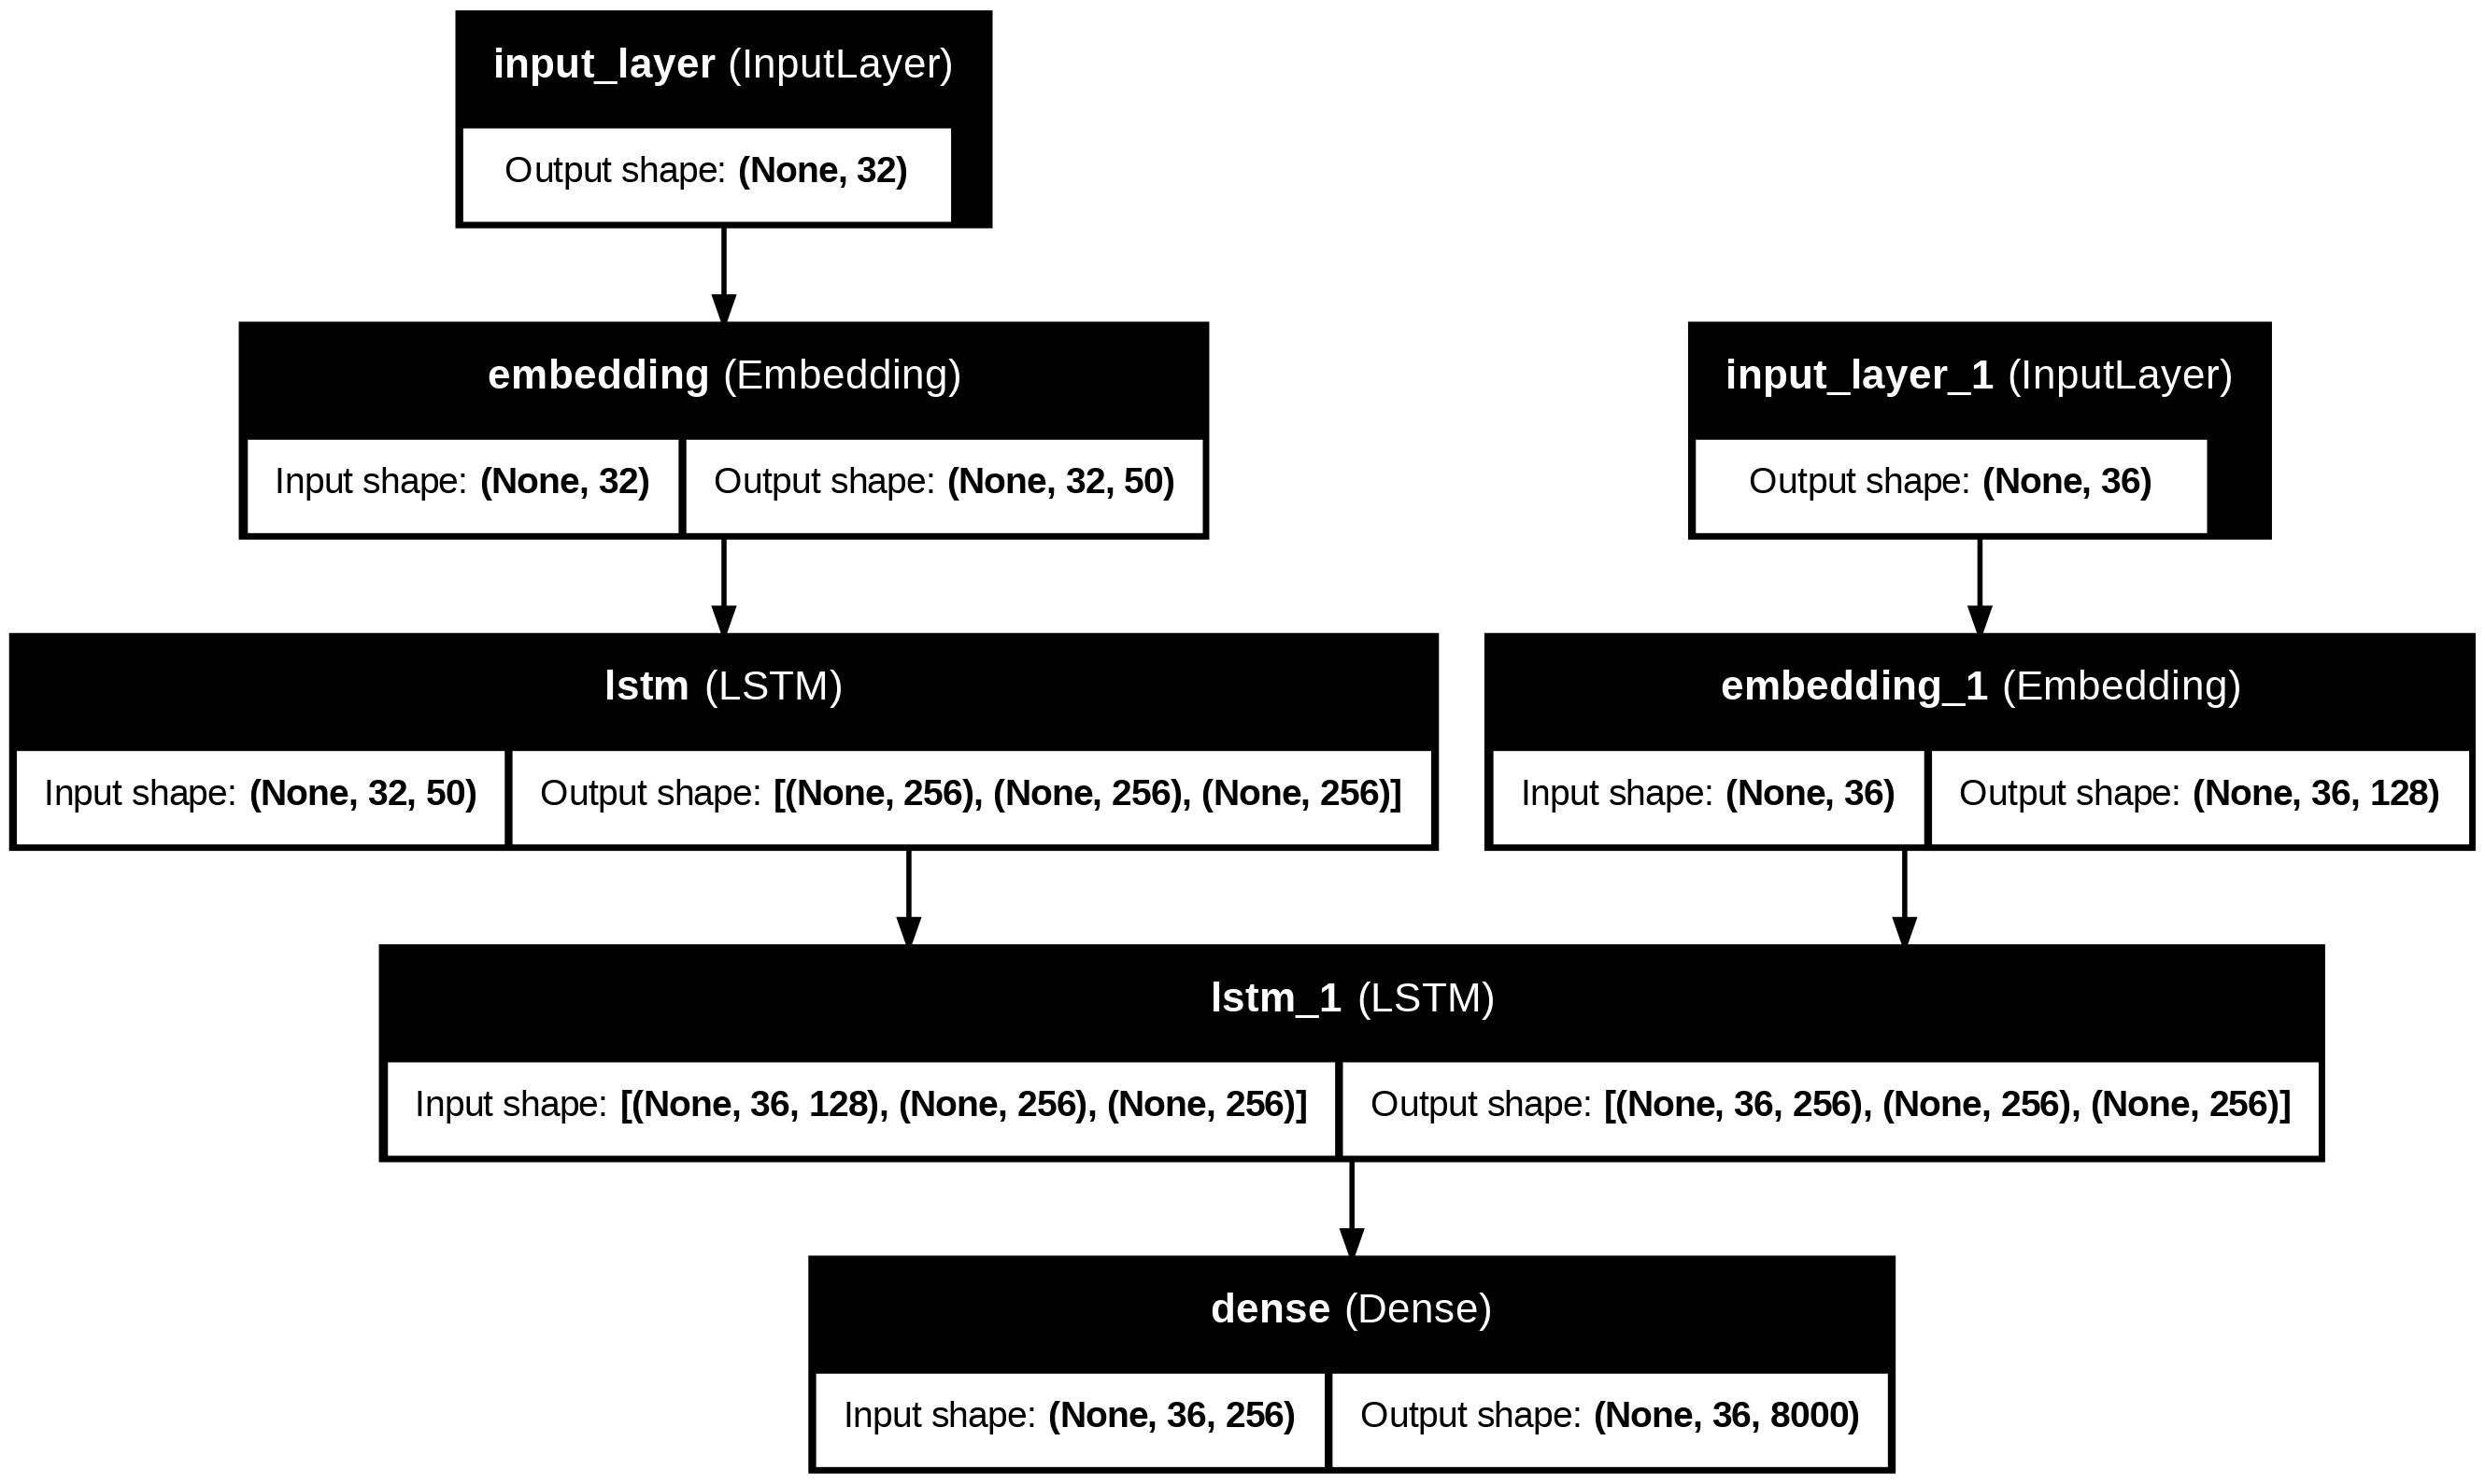

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

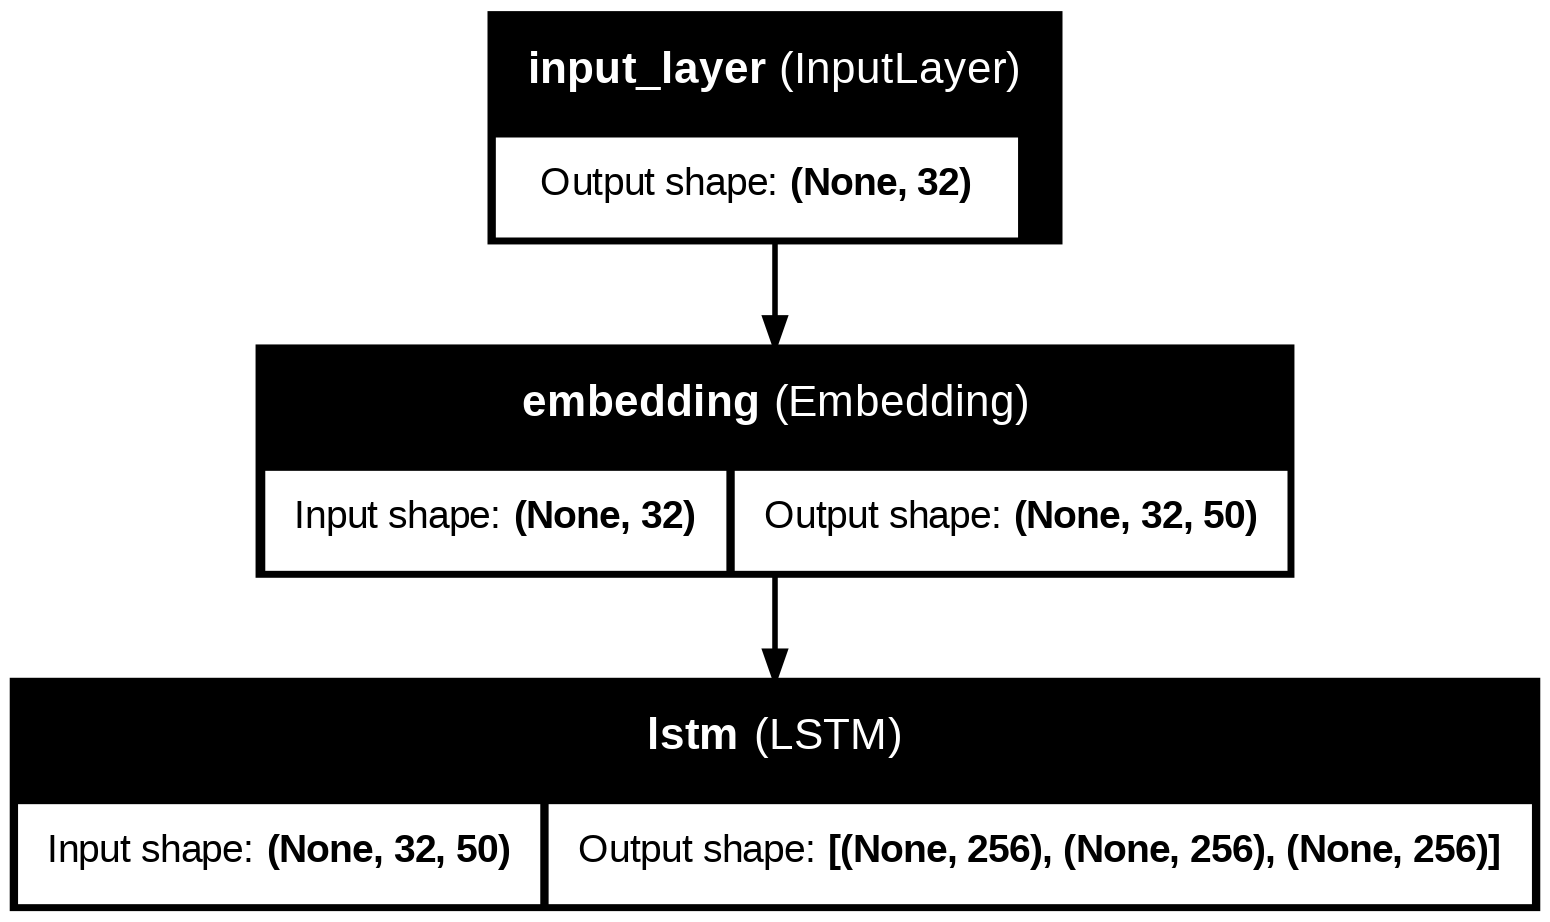

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

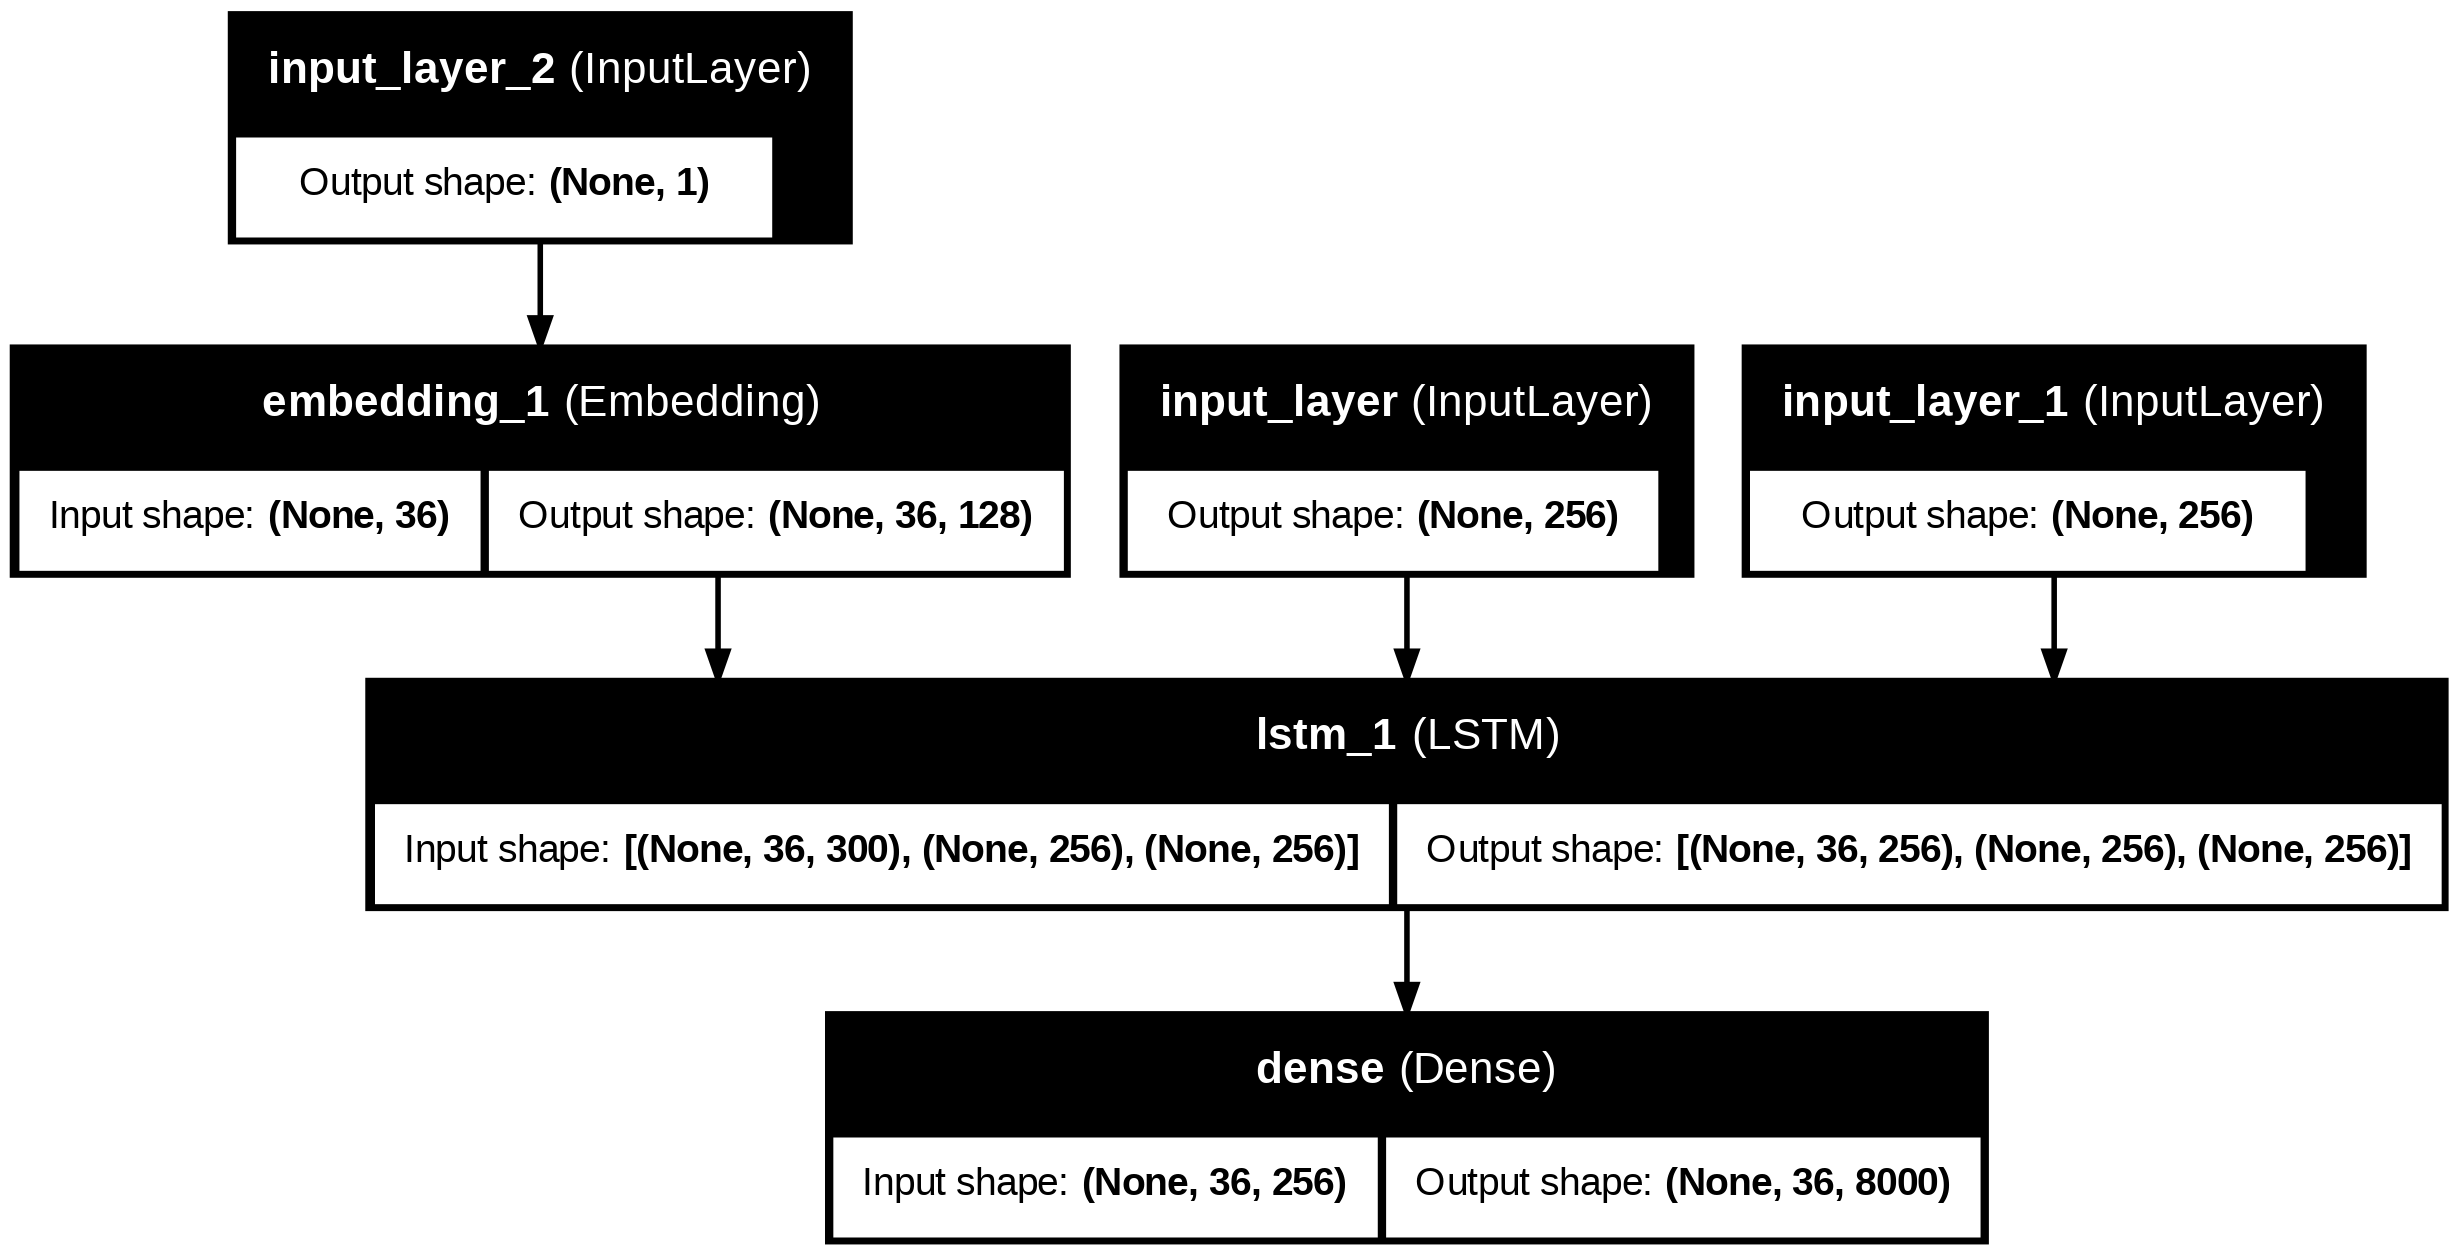

In [ ]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

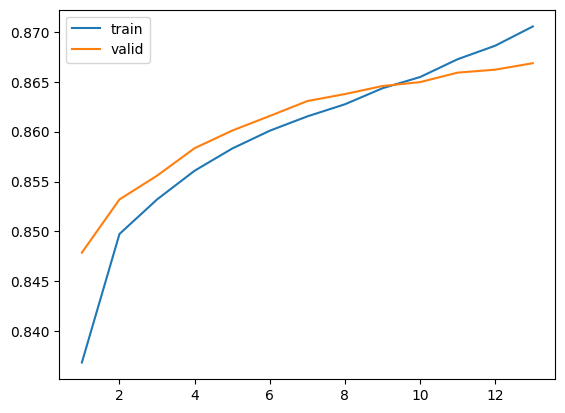

In [26]:
metric = "accuracy"
val_metric = "val_accuracy"

epoch_count = range(1, len(hist.history[metric]) + 1)
sns.lineplot(x=epoch_count, y=hist.history[metric], label="train")
sns.lineplot(x=epoch_count, y=hist.history[val_metric], label="valid")
plt.show()

Cargamos el mejor modelo:

In [33]:
best_model = tf.keras.models.load_model("best_seq2seq.keras")
BEST_UNITS = best_units

In [ ]:
def build_inference_from_saved(trained_model, max_input_len, num_words_output):
    emb_layers   = [l for l in trained_model.layers if isinstance(l, tf.keras.layers.Embedding)]
    lstm_layers  = [l for l in trained_model.layers if isinstance(l, tf.keras.layers.LSTM)]
    dense_layers = [l for l in trained_model.layers if isinstance(l, tf.keras.layers.Dense)]

    # Encoder LSTM
    encoder_lstm = next((l for l in lstm_layers if not l.return_sequences), None)
    # Decoder LSTM: return_sequences=True (típico)
    decoder_lstm = next((l for l in lstm_layers if l.return_sequences), None)

    # Input-dim esperado por cada LSTM
    enc_expected_dim = int(encoder_lstm.weights[0].shape[0])
    dec_expected_dim = int(decoder_lstm.weights[0].shape[0])

    # Elegir embeddings por output_dim que matchee lo que espera cada LSTM
    encoder_emb = next((e for e in emb_layers if int(e.output_dim) == enc_expected_dim), None)
    decoder_emb = next((e for e in emb_layers if int(e.output_dim) == dec_expected_dim), None)

    # Dense final
    decoder_dense = next((d for d in dense_layers if getattr(d, "units", None) == num_words_output), None)
    if decoder_dense is None:
        # fallback: el Dense con mayor units
        decoder_dense = max(dense_layers, key=lambda d: int(getattr(d, "units", 0)))

    n_units = int(decoder_lstm.units)

    # Encoder inference
    enc_in = tf.keras.Input(shape=(max_input_len,), dtype="int32", name="enc_in")
    x = encoder_emb(enc_in)
    _, h, c = encoder_lstm(x)
    encoder_model = tf.keras.Model(enc_in, [h, c], name="encoder_model")

    # Decoder inference
    dec_in = tf.keras.Input(shape=(1,), dtype="int32", name="dec_in")
    h_in = tf.keras.Input(shape=(n_units,), name="h_in")
    c_in = tf.keras.Input(shape=(n_units,), name="c_in")

    x = decoder_emb(dec_in)
    out, h2, c2 = decoder_lstm(x, initial_state=[h_in, c_in])
    out = decoder_dense(out)
    decoder_model = tf.keras.Model([dec_in, h_in, c_in], [out, h2, c2], name="decoder_model")

    return encoder_model, decoder_model, n_units

encoder_model, decoder_model, BEST_UNITS = build_inference_from_saved(
    best_model,
    max_input_len=max_input_len,
    num_words_output=num_words_output
)

In [41]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

Implementamos tres estategias de generación:

1. Greedy.

2. Sampling.

3. Beam Search.

In [ ]:
def translate_sentence(input_seq, method="greedy", temperature=0.8, beam_width=5):

    def _sample_with_temperature(probs, temperature=0.8):
        T = float(temperature)
        if T <= 0:
            raise ValueError("temperature debe ser > 0")

        p = probs.astype(np.float64)
        p = np.maximum(p, 1e-12)
        logits = np.log(p) / T
        logits = logits - np.max(logits)
        pT = np.exp(logits)
        pT = pT / np.sum(pT)
        return int(np.random.choice(len(pT), p=pT))



    states_value0 = encoder_model.predict(input_seq)

    sos = word2idx_outputs["<sos>"]
    eos = word2idx_outputs["<eos>"]

    method = method.lower().strip()
    if method not in ("greedy", "sampling", "beam_search"):
        raise ValueError("method debe ser 'greedy', 'sampling' o 'beam_search'")

    # -------- greedy / sampling --------
    if method in ("greedy", "sampling"):
        target_seq = np.zeros((1, 1), dtype="int32")
        target_seq[0, 0] = word2idx_outputs["<sos>"]

        output_sentence = []
        states_value = states_value0

        for _ in range(max_out_len):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
            probs = output_tokens[0, 0, :]

            if method == "greedy":
                idx = int(np.argmax(probs))
            else:
                idx = _sample_with_temperature(probs, temperature=temperature)

            if idx == eos:
                break

            if idx > 0:
                output_sentence.append(idx2word_target[idx])

            states_value = [h, c]
            target_seq[0, 0] = idx

        return " ".join(output_sentence)

    # -------- beam search --------
    if beam_width < 1:
        raise ValueError("beam_width debe ser >= 1")

    # beam: (seq_idxs, score_logprob, states_value, last_token)
    beams = [([], 0.0, states_value0, sos)]
    completed = []

    for _ in range(max_out_len):
        new_beams = []

        for seq, score, states_value, last_tok in beams:
            if last_tok == eos:
                completed.append((seq, score))
                continue

            target_seq = np.array([[last_tok]], dtype=np.float32)
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

            probs = output_tokens[0, 0, :].astype(np.float64)
            probs = np.maximum(probs, 1e-12)

            topk_idx = np.argpartition(-probs, beam_width)[:beam_width]
            topk_idx = topk_idx[np.argsort(-probs[topk_idx])]

            for idx in topk_idx:
                idx = int(idx)
                new_seq = seq + ([] if idx == eos else [idx])
                new_score = score + float(np.log(probs[idx]))
                new_states = [h, c]
                new_beams.append((new_seq, new_score, new_states, idx))

        if not new_beams:
            break

        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_width]

        if all(last_tok == eos for *_, last_tok in beams):
            break

    if completed:
        best_seq, _ = max(completed, key=lambda x: x[1])
    else:
        best_seq, *_ = max(beams, key=lambda x: x[1])

    words = [idx2word_target[i] for i in best_seq if i > 0]
    return " ".join(words)

**Ejemplo de traducciones:**

Al ejemplo visto en clase agregamos otros 5 ejemplos:

In [43]:
lista_input_test = ["My mother say hi.", "Can I go to the bathroom, please", "I don't understand.", "Would you like a cup of coffee", "Life is like riding a bicycle. To keep your balance, you must keep moving.", "How does it feel. How does it feel to be without a home, like a complete unknown, like a rolling stone."]

def test_traducciones(lista_input_test):
    for input_test in lista_input_test:
        for method in ("greedy", "sampling", "beam_search"):
            print('-'*80)
            print('Método:', method)
            print('Input:', input_test)
            integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
            print("Representacion en vector de tokens de ids", integer_seq_test)
            encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len).astype("int32")
            print("Padding del vector:", encoder_sequence_test)

            translation = translate_sentence(encoder_sequence_test, method)
            print('Response:', translation)
            print('-'*80)
            print('')


test_traducciones(lista_input_test)

--------------------------------------------------------------------------------
Método: greedy
Input: My mother say hi.
Representacion en vector de tokens de ids [17, 215, 118, 2525]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    17  215  118 2525]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Response: mi madre tiene dos hijos
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Método: sampling
Input: My mother say hi.
Representacion en vector de tokens de ids [17, 215, 118, 2525]
Padding del vector: [[   0    0    0    0    0    0    0 

**Conclusiones:**

Mejor modelo:
  1. n_units = 256
  2. Embeddings de salida pre-entrenados = False
  3. Mejor val_loss = 0.7114
  4. Epochs = 12

El desempeño de generación muestra que un *val_loss* relativamente bueno no garantiza traducciones correctas en la inferencia.

**Estrategias de generación:**

* *Greedy* tiende a producir salidas cortas, genéricas o repetitivas (“yo no…”, “el año pasado…” repetido), y a veces deriva a frases coherentes pero incorrectas (“puedo ir a la escuela” por “bathroom”).

* *Sampling* introduce variación, pero en los degrada la coherencia: aparecen frases con sintaxis extraña o contenido inventado (“puedo poner algo de resolver…”, “le duele la estómago”).

* *Beam Search* fue el más confiable: logra la mejor traducción (“te gustaría una taza de café”) y en general da salidas más coherentes, aunque todavía falla en significado (“puedo ir al cine”, “mi madre ha cambiado”).

**Dependencia de la longitud:**

Cuanto más larga y compleja es la oración, peor el resultado para las tres estrategias. En los ejemplos largos aparecen frases incoherentes y repetitivas, lo que muestra que el modelo tiene problemas para mantener el contenido a lo largo de muchos pasos.

In [45]:
print(f"Tiempo total ejecución: {datetime.datetime.now() - INICIO_EJECUCION}")

Tiempo total ejecución: 2:25:38.455038


---